# Mini Lab 9: Topic Modeling

<a target="_blank" href="https://colab.research.google.com/github/browndw/humanities_analytics/blob/main/mini_labs/Mini_Lab_09_Topic_Modeling.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

This lab provides a brief introduction to topic modeling. Ted Underwood has a nice explanation of one common technique (Latent Dirichlet Allocation or LDA) [here](https://tedunderwood.com/2012/04/07/topic-modeling-made-just-simple-enough/). And he has another exploration [here](https://tedunderwood.com/2012/04/01/what-kinds-of-topics-does-topic-modeling-actually-produce/). There is also [a review of some projects with links](https://medium.com/@neala/a-review-of-topic-modeling-projects-941922a1216c).

## Install the libraries

There are a wide range of tools to use for topic modeling in Python. We're going to use [tmtoolkit](https://tmtoolkit.readthedocs.io/en/latest/), as it interacts with a number of other libraries and does spaCy processing under the hood (so we can do things like easily lemmatize a text).

In [1]:
%%capture
!pip install -U "tmtoolkit[recommended,lda,sklearn,gensim]"
!pip install lda

## Load the libraries

We'll need these for our proceessing pipeline (docuscospacy, spacy) wrangle data frames (polars), generate and maipulate tables (great_tables) and create plots (matplotlib).

In [2]:
import logging
import warnings
import numpy as np
import pandas as pd
from copy import copy
from tmtoolkit.topicmod.evaluate import results_by_parameter
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words
from tmtoolkit.topicmod.tm_lda import compute_models_parallel, evaluate_topic_models
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words, ldamodel_top_topic_words, ldamodel_top_topic_docs, ldamodel_full_doc_topics
from tmtoolkit.topicmod.visualize import plot_eval_results
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.utils import disable_logging
from tmtoolkit.corpus import (
    Corpus, dtm, print_summary, lemmatize, to_lowercase,
    remove_punctuation, filter_clean_tokens, filter_for_pos,
    remove_common_tokens, remove_uncommon_tokens
    )


## Import data

We can use the `from_tabular` function to import a `.csv` table specifying a text column and an id column:

In [3]:
corp = Corpus.from_tabular("https://github.com/browndw/humanities_analytics/raw/refs/heads/main/data/data_tables/inaugural_subset.csv",
                         text_column='text', id_column='year', language='en')

Now we can print a summary of the corpus:

In [4]:
print_summary(corp)

Corpus with 32 documents in English
> inaugural_subset-1921 (3753 tokens): My Countrymen : When one surveys the world about h...
> inaugural_subset-1929 (3891 tokens): My Countrymen : This occasion is not alone the adm...
> inaugural_subset-1901 (2451 tokens): My fellow - citizens , when we assembled here on t...
> inaugural_subset-1905 (1090 tokens): My fellow citizens , no people on earth have more ...
> inaugural_subset-1937 (2021 tokens): When four years ago we met to inaugurate a Preside...
> inaugural_subset-1925 (4442 tokens): My countrymen , no one can contemplate current con...
> inaugural_subset-1909 (5845 tokens): My fellow citizens : Anyone who has taken the oath...
> inaugural_subset-1933 (2063 tokens): I am certain that my fellow Americans expect that ...
> inaugural_subset-1913 (1901 tokens): There has been a change of government . It began t...
> inaugural_subset-1917 (1656 tokens): My Fellow citizens : The four years which have ela...
(and 22 more documents)
total numb

Now we will lemmatize the corpus, convert tokens to lower case, and remove punctuation. 

**Why lemmatize for topic modeling?** Lemmatization groups together inflected forms (e.g., "governing," "governed," "governs" → "govern"), which increases statistical power. Without lemmatization, each form would be treated as a separate word, fragmenting the probability distribution and making topics harder to interpret.

In [5]:
lemmatize(corp)
to_lowercase(corp)
remove_punctuation(corp)

print_summary(corp)

Corpus with 32 documents in English
> inaugural_subset-1921 (3753 tokens): my countryman  when one survey the world about he ...
> inaugural_subset-1929 (3891 tokens): my countryman  this occasion be not alone the admi...
> inaugural_subset-1901 (2451 tokens): my fellow  citizen  when we assemble here on the 4...
> inaugural_subset-1905 (1090 tokens): my fellow citizen  no people on earth have more ca...
> inaugural_subset-1937 (2021 tokens): when four year ago we meet to inaugurate a preside...
> inaugural_subset-1925 (4442 tokens): my countryman  no one can contemplate current cond...
> inaugural_subset-1909 (5845 tokens): my fellow citizen  anyone who have take the oath i...
> inaugural_subset-1933 (2063 tokens): i be certain that my fellow americans expect that ...
> inaugural_subset-1913 (1901 tokens): there have be a change of government  it begin two...
> inaugural_subset-1917 (1656 tokens): my fellow citizen  the four year which have elapse...
(and 22 more documents)
total numb

## Creating two versions of our corpus

We'll create two versions to compare how preprocessing choices affect topic quality:

For the **larger corpus**, we'll remove short words, highly frequent tokens, and extremely rare tokens. This preserves more lexical variety while filtering noise.

In [6]:
corp_bigger = copy(corp)

filter_clean_tokens(corp_bigger, remove_shorter_than=2)
remove_common_tokens(corp_bigger, df_threshold=0.85)
remove_uncommon_tokens(corp_bigger, df_threshold=0.05)

print_summary(corp_bigger)

Corpus with 32 documents in English
> inaugural_subset-1921 (1194 tokens): countryman survey storm note mark destruction rejo...
> inaugural_subset-1929 (1264 tokens): countryman occasion administration sacred oath ass...
> inaugural_subset-1901 (759 tokens): fellow assemble march anxiety regard currency cred...
> inaugural_subset-1905 (299 tokens): fellow earth cause thankful say reverently spirit ...
> inaugural_subset-1937 (633 tokens): ago meet inaugurate president republic single mind...
> inaugural_subset-1925 (1354 tokens): countryman contemplate current condition find sati...
> inaugural_subset-1909 (1862 tokens): fellow take oath take feel heavy weight responsibi...
> inaugural_subset-1933 (682 tokens): certain fellow americans expect induction presiden...
> inaugural_subset-1913 (517 tokens): change begin ago house democratic decisive majorit...
> inaugural_subset-1917 (460 tokens): fellow place crowd counsel action vital interest c...
(and 22 more documents)
total number of 

For the **smaller corpus**, we'll do similar filtering while also restricting to **nouns only**. This produces more semantically focused topics (places, concepts, actors) at the cost of losing grammatical context.

In [7]:
corp_smaller = copy(corp)

filter_for_pos(corp_smaller, 'N')
filter_clean_tokens(corp_smaller, remove_shorter_than=2)
remove_common_tokens(corp_smaller, df_threshold=0.8)
remove_uncommon_tokens(corp_smaller, df_threshold=0.1)

In [ ]:
print_summary(corp_smaller)

Corpus with 32 documents in English
> inaugural_subset-1929 (603 tokens): countryman occasion administration oath dedication...
> inaugural_subset-1921 (485 tokens): countryman storm destruction thing american passio...
> inaugural_subset-1913 (241 tokens): change house majority senate office president vice...
> inaugural_subset-1909 (778 tokens): oath weight responsibility conception duty office ...
> inaugural_subset-1925 (532 tokens): countryman condition result conflict burden effect...
> inaugural_subset-1933 (290 tokens): americans presidency decision truth truth conditio...
> inaugural_subset-1917 (180 tokens): place counsel action interest consequence period h...
> inaugural_subset-1901 (309 tokens): fellow march anxiety regard currency credit obliga...
> inaugural_subset-1937 (263 tokens): president republic anxiety spirit fulfillment visi...
> inaugural_subset-1905 (128 tokens): earth cause spirit strength good condition measure...
(and 22 more documents)
total number of toke

Next, we'll create document-term matrices (DTMs):

In [8]:
dtm_bg, doc_labels_bg, vocab_bg = dtm(corp_bigger, return_doc_labels=True, return_vocab=True)
dtm_sm, doc_labels_sm, vocab_sm = dtm(corp_smaller, return_doc_labels=True, return_vocab=True)

dtm_bg, dtm_sm

(<Compressed Sparse Row sparse matrix of dtype 'int32'
 	with 13741 stored elements and shape (32, 2439)>,
 <Compressed Sparse Row sparse matrix of dtype 'int32'
 	with 5447 stored elements and shape (32, 646)>)

## Generating topic models

Now we generate two models using **LDA** (Latent Dirichlet Allocation). LDA assumes that:
1. Each document is a mixture of topics
2. Each topic is a probability distribution over words
3. Both are inferred from the data

We set **n_topics=10** as a starting point and **n_iter=1000** iterations for the algorithm to converge.

In [9]:
# disable tmtoolkit logging for now (too much output)
disable_logging()

# suppress the "INFO" messages and warnings from lda
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False

warnings.filterwarnings('ignore')

# set data to use
dtms = {
    'bigger': dtm_bg,
    'smaller': dtm_sm
}

# and fixed hyperparameters
lda_params = {
    'n_topics': 10,
    'n_iter': 1000,
    'random_state': 20191122  # to make results reproducible
}

models = compute_models_parallel(dtms, constant_parameters=lda_params)

INFO:lda:n_documents: 32
INFO:lda:vocab_size: 646
INFO:lda:n_words: 9583
INFO:lda:n_topics: 10
INFO:lda:n_iter: 1000
INFO:lda:n_documents: 32
INFO:lda:vocab_size: 2439
INFO:lda:n_words: 23025
INFO:lda:n_topics: 10
INFO:lda:n_iter: 1000
INFO:lda:<0> log likelihood: -96194
INFO:lda:<10> log likelihood: -66119
INFO:lda:<20> log likelihood: -64848
INFO:lda:<0> log likelihood: -254667
INFO:lda:<30> log likelihood: -64063
INFO:lda:<10> log likelihood: -187755
INFO:lda:<40> log likelihood: -64194
INFO:lda:<50> log likelihood: -63724
INFO:lda:<20> log likelihood: -182771
INFO:lda:<60> log likelihood: -63613
INFO:lda:<70> log likelihood: -63450
INFO:lda:<30> log likelihood: -181554
INFO:lda:<80> log likelihood: -63702
INFO:lda:<40> log likelihood: -180806
INFO:lda:<90> log likelihood: -63178
INFO:lda:<100> log likelihood: -63411
INFO:lda:<50> log likelihood: -180373
INFO:lda:<110> log likelihood: -63461
INFO:lda:<120> log likelihood: -63432
INFO:lda:<60> log likelihood: -179897
INFO:lda:<130> l

In [ ]:
models

defaultdict(list,
            {'smaller': [({'n_topics': 10,
                'n_iter': 1000,
                'random_state': 20191122},
               <lda.lda.LDA at 0x7fa1ff71b410>)],
             'bigger': [({'n_topics': 10,
                'n_iter': 1000,
                'random_state': 20191122},
               <lda.lda.LDA at 0x7fa1fe3900d0>)]})

Now, let's examine the composition of our topic models by checking the top 3 words in each. These high-probability words serve as **interpretive lenses**—we assign meaning to topics based on which words co-occur most strongly.

In [10]:
model_sm = models['smaller'][0][1]
print_ldamodel_topic_words(model_sm.topic_word_, vocab_sm, top_n=3)

topic_1
> #1. states (0.074897)
> #2. united (0.071776)
> #3. effort (0.040574)
topic_2
> #1. progress (0.063210)
> #2. opportunity (0.062039)
> #3. system (0.051506)
topic_3
> #1. responsibility (0.037967)
> #2. republic (0.036021)
> #3. law (0.031154)
topic_4
> #1. law (0.073032)
> #2. business (0.046790)
> #3. congress (0.039945)
topic_5
> #1. strength (0.082568)
> #2. earth (0.076775)
> #3. place (0.042015)
topic_6
> #1. spirit (0.056502)
> #2. thing (0.054933)
> #3. task (0.036102)
topic_7
> #1. change (0.068062)
> #2. self (0.050717)
> #3. success (0.044045)
topic_8
> #1. americans (0.064891)
> #2. history (0.059609)
> #3. president (0.052819)
topic_9
> #1. generation (0.045535)
> #2. word (0.041489)
> #3. moment (0.041489)
topic_10
> #1. right (0.058935)
> #2. liberty (0.040035)
> #3. party (0.038923)


In [ ]:
model_bg = models['bigger'][0][1]
print_ldamodel_topic_words(model_bg.topic_word_, vocab_bg, top_n=3)

topic_1
> #1. policy (0.032153)
> #2. condition (0.021223)
> #3. congress (0.018651)
topic_2
> #1. change (0.028001)
> #2. let (0.025456)
> #3. generation (0.024608)
topic_3
> #1. united (0.028138)
> #2. power (0.025974)
> #3. free (0.022006)
topic_4
> #1. law (0.031909)
> #2. justice (0.023371)
> #3. peace (0.022922)
topic_5
> #1. freedom (0.048025)
> #2. liberty (0.031263)
> #3. cause (0.019938)
topic_6
> #1. america (0.071512)
> #2. let (0.025968)
> #3. child (0.022989)
topic_7
> #1. believe (0.032713)
> #2. human (0.032225)
> #3. freedom (0.026367)
topic_8
> #1. business (0.029657)
> #2. administration (0.021922)
> #3. federal (0.021922)
topic_9
> #1. shall (0.038949)
> #2. war (0.036250)
> #3. purpose (0.029309)
topic_10
> #1. peace (0.032266)
> #2. history (0.021975)
> #3. help (0.020307)


## Evaluating topic models

One of the most powerful features of `tmtoolkit` is its ability to generate **many topic models** of varying sizes (k=5, 10, 15, ..., 45) and evaluate them using statistical measures:

- **Perplexity**: How well the model predicts held-out data (lower is better)
- **Coherence (Mimno 2011)**: How semantically related the top words in each topic are (higher is better)

This process takes a few minutes as it trains 9 different models...

In [ ]:
var_params = [{'n_topics': k, 'alpha': 1/k}
               for k in range(5, 50, 5)] #topic size from 5 to 50 in increments of 5

const_params = {
    'n_iter': 1000,
    'random_state': 20191122,  # to make results reproducible
    'eta': 0.1,                # sometimes also called "beta"
}

eval_results = evaluate_topic_models(dtm_bg,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     coherence_mimno_2011_top_n=10,
                                     coherence_mimno_2011_include_prob=True,
                                     return_models=True)
eval_results[:3]  # only show first three models

[({'n_topics': 5,
   'alpha': 0.2,
   'n_iter': 1000,
   'random_state': 20191122,
   'eta': 0.1},
  {'model': <lda.lda.LDA at 0x7fa200acb610>,
   'cao_juan_2009': 0.18230030224073085,
   'coherence_mimno_2011': -419.59042139370615}),
 ({'n_topics': 10,
   'alpha': 0.1,
   'n_iter': 1000,
   'random_state': 20191122,
   'eta': 0.1},
  {'model': <lda.lda.LDA at 0x7fa20f3ecc50>,
   'cao_juan_2009': 0.16523234775742937,
   'coherence_mimno_2011': -412.1745323280584}),
 ({'n_topics': 15,
   'alpha': 0.06666666666666667,
   'n_iter': 1000,
   'random_state': 20191122,
   'eta': 0.1},
  {'model': <lda.lda.LDA at 0x7fa200abe8d0>,
   'cao_juan_2009': 0.1414363674572127,
   'coherence_mimno_2011': -415.60422099236973})]

Now let's examine the evaluation results organized by number of topics. We're looking for the **optimal k** where coherence is maximized without overfitting (too many granular topics).

In [ ]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_topics')
eval_results_by_topics[:3]  # again only the first three models

[(5,
  {'model': <lda.lda.LDA at 0x7fa200acb610>,
   'cao_juan_2009': 0.18230030224073085,
   'coherence_mimno_2011': -419.59042139370615}),
 (10,
  {'model': <lda.lda.LDA at 0x7fa20f3ecc50>,
   'cao_juan_2009': 0.16523234775742937,
   'coherence_mimno_2011': -412.1745323280584}),
 (15,
  {'model': <lda.lda.LDA at 0x7fa200abe8d0>,
   'cao_juan_2009': 0.1414363674572127,
   'coherence_mimno_2011': -415.60422099236973})]

And visualize the evaluation metrics across different values of k. Look for where coherence peaks and perplexity stabilizes:

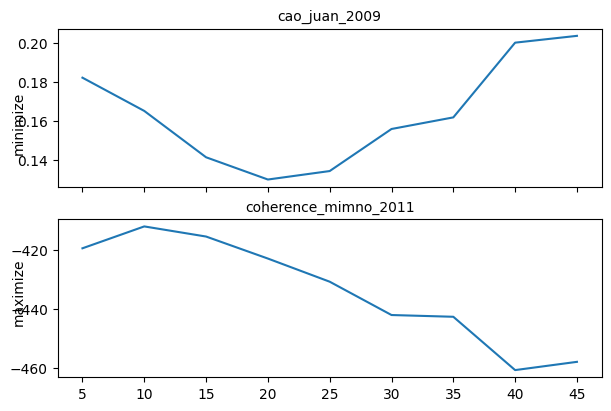

In [ ]:
plot_eval_results(eval_results_by_topics);

The plots suggest peak coherence around **k=20** and perplexity stabilization around **k=10**. We'll split the difference and select **k=15** as our final model—a balance between interpretability (not too many topics) and granularity (capturing distinct themes).

In [ ]:
best_tm = [m for k, m in eval_results_by_topics if k == 15][0]['model']
best_tm.n_topics, best_tm.alpha, best_tm.eta  # just to make sure

(15, 0.06666666666666667, 0.1)

In topic modeling, topics are numbered because they're abstract -- they're simply a probability distribution across all words in the vocabulary. Still, it's useful to give them labels for better identification. The function `generate_topic_labels_from_top_words` is very useful for that, as it finds labels according to the most “relevant” words in each topic. We'll later see how we can identify the most relevant words per topic using a special relevance statistic. Note that you can adjust the weight of the relevance measure for the ranking by using the parameter `lambda_` which is in range [0-1].

The function requires at least the topic-word and document-topic distributions from the model, the document lengths and the vocabulary. It then finds the minimum number of relevant words that uniquely label each topic. You can also use a fixed number for that minimum number with the parameter `n_words`.

In [ ]:
vocab_bg = np.array(vocab_bg)   # we need this to be an array

doc_lengths_bg = doc_lengths(dtm_bg)
topic_labels = generate_topic_labels_from_top_words(
    best_tm.topic_word_,
    best_tm.doc_topic_,
    doc_lengths_bg,
    np.array(vocab_bg),
    lambda_=0.6
)

topic_labels[:15]   # showing only the first 5 topics here

array(['1_americans', '2_congress', '3_justice', '4_heritage',
       '5_counsel', '6_leadership', '7_freedom', '8_shall', '9_thank',
       '10_peace', '11_federal', '12_journey', '13_let', '14_republic',
       '15_business'], dtype='<U12')

In [ ]:
top_topic_word = ldamodel_top_topic_words(best_tm.topic_word_,
                                          vocab_bg,
                                          row_labels=topic_labels)
top_topic_word[top_topic_word.index == '12_journey']

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
12_journey,america (0.02066),child (0.01339),journey (0.01339),promise (0.01339),common (0.01278),choice (0.01157),require (0.01036),care (0.009752),define (0.009752),value (0.009147)


In [ ]:
ldamodel_top_topic_docs(best_tm.doc_topic_, doc_labels_bg, top_n=3,
                        topic_labels=topic_labels)

,rank_1,rank_2,rank_3
topic,,,
1_americans,inaugural_subset-1945 (0.5926),inaugural_subset-1989 (0.5831),inaugural_subset-2021 (0.5804)
2_congress,inaugural_subset-1925 (0.4039),inaugural_subset-1901 (0.3998),inaugural_subset-1909 (0.2646)
3_justice,inaugural_subset-1929 (0.3371),inaugural_subset-1937 (0.2281),inaugural_subset-1925 (0.1731)
4_heritage,inaugural_subset-1961 (0.3562),inaugural_subset-1965 (0.2211),inaugural_subset-1981 (0.1652)
5_counsel,inaugural_subset-1913 (0.4215),inaugural_subset-1917 (0.2518),inaugural_subset-1925 (0.07106)
6_leadership,inaugural_subset-1933 (0.2629),inaugural_subset-1989 (0.1912),inaugural_subset-1977 (0.03588)
7_freedom,inaugural_subset-1949 (0.3271),inaugural_subset-2005 (0.2962),inaugural_subset-1941 (0.2911)
8_shall,inaugural_subset-1905 (0.5536),inaugural_subset-1917 (0.4427),inaugural_subset-1937 (0.302)
9_thank,inaugural_subset-2017 (0.4907),inaugural_subset-2025 (0.4286),inaugural_subset-1969 (0.1513)


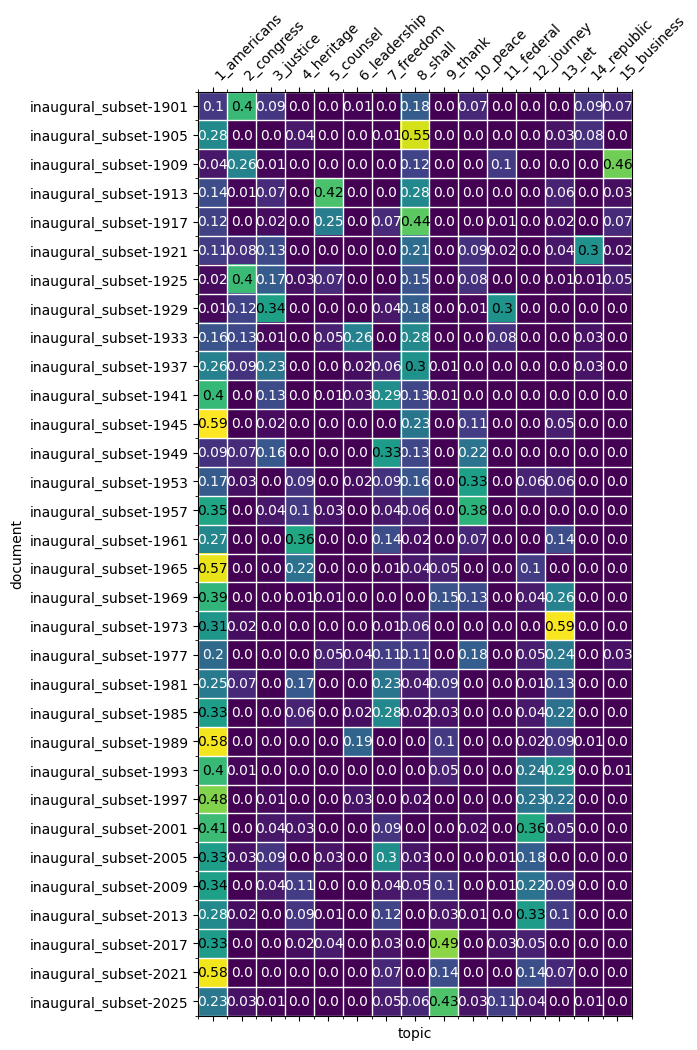

In [ ]:
import matplotlib.pyplot as plt
from tmtoolkit.topicmod.visualize import plot_doc_topic_heatmap


# create a figure of certain size and
# Axes object to draw on
fig, ax = plt.subplots(figsize=(32, 12))


plot_doc_topic_heatmap(fig, ax, best_tm.doc_topic_, doc_labels_bg,
                       topic_labels=topic_labels);

In [ ]:
df_doc_topic = ldamodel_full_doc_topics(best_tm.doc_topic_,
                                        doc_labels_bg,
                                        topic_labels=topic_labels)
df_doc_topic.head(10)

,_doc,1_americans,2_congress,3_justice,4_heritage,5_counsel,6_leadership,7_freedom,8_shall,9_thank,10_peace,11_federal,12_journey,13_let,14_republic,15_business
0,inaugural_subset-1901,0.098384,0.399825,0.094452,0.000087,0.000087,0.006640,0.000087,0.175710,0.000087,0.068239,0.000087,0.000087,0.000087,0.087899,0.068239
1,inaugural_subset-1905,0.283556,0.000222,0.000222,0.040222,0.000222,0.000222,0.006889,0.553556,0.000222,0.000222,0.000222,0.000222,0.030222,0.080222,0.003556
2,inaugural_subset-1909,0.038290,0.264583,0.009734,0.000036,0.000036,0.000575,0.002191,0.119648,0.000036,0.000036,0.100790,0.000036,0.000036,0.000575,0.463398
3,inaugural_subset-1913,0.139935,0.009838,0.070032,0.000129,0.421489,0.000129,0.000129,0.275858,0.000129,0.000129,0.000129,0.000129,0.056440,0.000129,0.025372
4,inaugural_subset-1917,0.117281,0.000145,0.019667,0.000145,0.251772,0.000145,0.071728,0.442661,0.000145,0.000145,0.006652,0.000145,0.019667,0.000145,0.069559
5,inaugural_subset-1921,0.108570,0.081024,0.134446,0.000056,0.000056,0.000056,0.000056,0.212910,0.000056,0.085198,0.017585,0.000056,0.037618,0.299722,0.022593
6,inaugural_subset-1925,0.017801,0.403895,0.173126,0.025937,0.071055,0.000049,0.000049,0.151677,0.000049,0.084369,0.000049,0.000049,0.007446,0.014103,0.050345
7,inaugural_subset-1929,0.011920,0.119515,0.337078,0.000053,0.000844,0.000053,0.040401,0.179641,0.000053,0.007964,0.301477,0.000053,0.000844,0.000053,0.000053
8,inaugural_subset-1933,0.156302,0.128564,0.011776,0.000097,0.051192,0.262871,0.000097,0.278929,0.000097,0.000097,0.080389,0.000097,0.000097,0.029294,0.000097
9,inaugural_subset-1937,0.261111,0.086583,0.228092,0.000105,0.001677,0.022117,0.058281,0.301992,0.006394,0.000105,0.000105,0.000105,0.000105,0.033124,0.000105


In [ ]:
df = pd.read_csv("https://github.com/browndw/humanities_analytics/raw/refs/heads/main/data/data_tables/inaugural_subset.csv")
df.head()

,year,president,doc_id,text
0,1901,McKinley,1901-McKinley,"My fellow-citizens, when we assembled here on ..."
1,1905,Roosevelt,1905-Roosevelt,"My fellow citizens, no people on earth have mo..."
2,1909,Taft,1909-Taft,My fellow citizens: Anyone who has taken the o...
3,1913,Wilson,1913-Wilson,There has been a change of government. It bega...
4,1917,Wilson,1917-Wilson,My Fellow citizens: The four years which have ...


In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

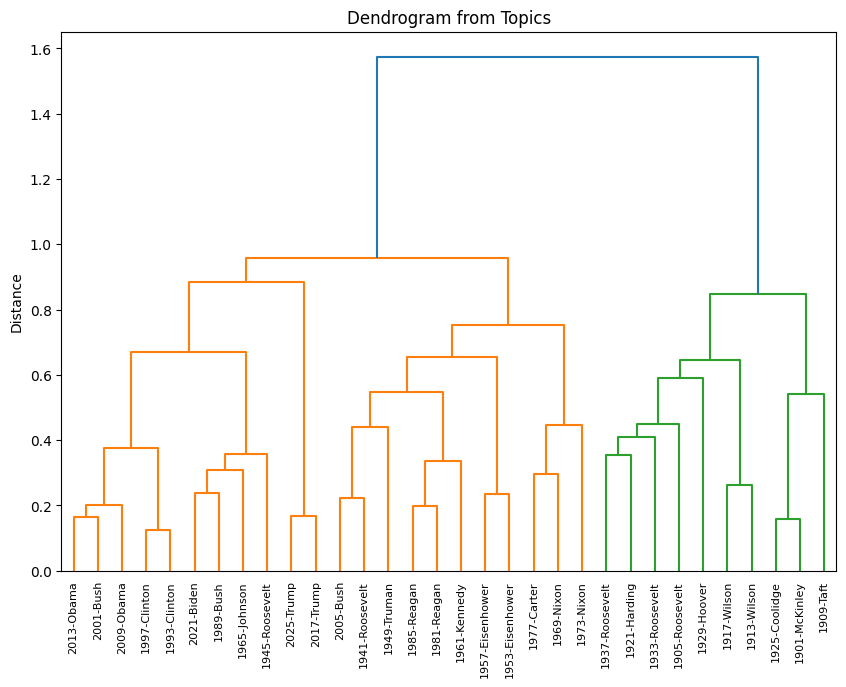

In [ ]:
data_array = df_doc_topic.select_dtypes(include=np.number)
linked = linkage(data_array, 'ward')  # 'ward' minimizes variance within clusters

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked,
            orientation='top',
            labels=df['doc_id'].tolist(),
            distance_sort='descending',
            leaf_rotation=90)
plt.title('Dendrogram from Topics')
plt.xlabel('')
plt.ylabel('Distance')
plt.show()

## Discussion Questions

1. **Preprocessing Effects**: Compare the topics from the "bigger" vs. "smaller" corpus models. How does filtering for nouns-only change the topics? What semantic information is lost?

2. **Optimal k Selection**: The evaluation plots show trade-offs between coherence and perplexity. Why might the "best" k for statistical coherence differ from the "best" k for historical interpretation?

3. **Topic Interpretation**: Examine the topic labels (e.g., "12_journey"). Do they reflect meaningful thematic clusters, or are they accidents of word co-occurrence? How would you validate a topic's interpretive significance?

4. **Document-Topic Distributions**: Look at the heatmap and dendrogram. Which presidential speeches cluster together? Do the clusters align with historical periods, political parties, or major events?

5. **Temporal Patterns**: Do certain topics dominate specific time periods? What might explain the rise or fall of topics like "war," "economy," or "freedom" across decades?

6. **Iteration Strategy**: The final question asks about tokens to remove for the next iteration. What criteria would you use—statistical (high frequency across all topics) or interpretive (noise words that muddy thematic clarity)?

## Experimentation Ideas

1. **Vary k systematically**: Run models with k=5, k=10, k=20, k=30. At what point do topics become too granular to interpret? Too coarse to be useful?

2. **Test different POS filters**: Try filtering for only verbs, or verbs+nouns. How do action-focused topics differ from concept-focused ones?

3. **Adjust threshold parameters**: Change `df_threshold` values for common/uncommon token removal. How sensitive are topics to these choices?

4. **Apply to a different corpus**: Try the inaugural corpus from a different time range (1900-1950 vs. 1950-2000). Do historical eras produce distinct topic structures?

5. **Examine topic evolution**: Create separate models for different decades and compare how the same topic label shifts in meaning over time.

6. **Investigate outlier documents**: Which speeches have unusual topic distributions (high concentration in one topic, or equal spread across many)? What makes them rhetorically distinct?

## Further study

If you're interested in exploring more:


*   tmtoolkit has [an extenstive vignette](https://tmtoolkit.readthedocs.io/en/latest/topic_modeling.html)
*   there is another Colab [here](https://colab.research.google.com/github/alvinntnu/NTNU_ENC2045_LECTURES/blob/main/nlp/topic-modeling-naive.ipynb)
*   a blog post explaining [tm evaluation is here](https://datascience.blog.wzb.eu/2017/11/09/topic-modeling-evaluation-in-python-with-tmtoolkit/)
*   visualizing [topic models](https://tedunderwood.com/2012/11/11/visualizing-topic-models/)
*   [graph neural topic models](https://github.com/SmilesDZgk/GNTM)
*   For short texts, [BERTopic](https://maartengr.github.io/BERTopic/index.html#quick-start)
*   About [BERTopic](https://www.maartengrootendorst.com/blog/bertopic/)